### Load Data and Model

In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName('ClusteredData') \
    .master('local[*]') \
    .getOrCreate()

In [19]:
from pyspark.sql.functions import *

In [10]:
input_path = '/home/jovyan/work/data/'
load_path=input_path+'clustered_data_users'

In [27]:
df = spark.read.csv(load_path, multiLine=True, header=True, inferSchema=True)

In [14]:
df.printSchema()

root
 |-- _AccountId: integer (nullable = true)
 |-- forum: string (nullable = true)
 |-- ActivityDays: double (nullable = true)
 |-- comments_number: double (nullable = true)
 |-- edits_of_answers: double (nullable = true)
 |-- edits_of_question: double (nullable = true)
 |-- created_questions: double (nullable = true)
 |-- comments_every_day: double (nullable = true)
 |-- activity_answer_edits: double (nullable = true)
 |-- activity_question_edits: double (nullable = true)
 |-- activity_questions: double (nullable = true)
 |-- prediction: integer (nullable = true)



In [17]:
# Number of users in each cluster
df.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|      null|    6|
|         1|68881|
|         6| 4422|
|         3| 7484|
|         5|14257|
|         4| 4116|
|         7|16901|
|         2|14977|
|         0|16533|
+----------+-----+



In [28]:
# remove values with null predictions
df = df.filter(df['prediction'].isNotNull())

In [33]:
# Number of users in each cluster
df.groupby('forum', 'prediction').count().orderBy('forum').show(50, truncate=False)

+-------------+----------+-----+
|forum        |prediction|count|
+-------------+----------+-----+
|chemistry    |1         |68881|
|chemistry    |3         |194  |
|chemistry    |7         |4035 |
|french       |3         |192  |
|french       |0         |16533|
|french       |7         |3632 |
|italian      |3         |5112 |
|italian      |7         |919  |
|mythology    |6         |4234 |
|mythology    |3         |47   |
|mythology    |7         |1795 |
|portuguese   |4         |4058 |
|portuguese   |3         |35   |
|portuguese   |7         |1011 |
|portuguese   |6         |35   |
|spanish      |5         |14257|
|spanish      |7         |3105 |
|spanish      |3         |151  |
|vegetarianism|6         |96   |
|vegetarianism|4         |25   |
|vegetarianism|3         |1710 |
|vegetarianism|2         |29   |
|vegetarianism|7         |1019 |
|windowsphone |2         |14948|
|windowsphone |4         |33   |
|windowsphone |3         |43   |
|windowsphone |7         |1385 |
|windowsph

In [49]:
forums_per_account = df.groupBy('_AccountId', 'prediction').agg(collect_set('forum').alias('joined_forums'))
users_in_forums = forums_per_account.groupBy('joined_forums', 'prediction').agg(count('_AccountId').alias('users'))
users_in_forums = users_in_forums.withColumn('array size', size(users_in_forums['joined_forums']))

In [52]:
users_in_forums['joined_forums', 'prediction', 'users'].orderBy('prediction').show(100, truncate=False)

+-----------------------------------------------------------------------------------------+----------+-----+
|joined_forums                                                                            |prediction|users|
+-----------------------------------------------------------------------------------------+----------+-----+
|[french]                                                                                 |0         |16533|
|[chemistry]                                                                              |1         |68881|
|[windowsphone]                                                                           |2         |14919|
|[vegetarianism, windowsphone]                                                            |2         |29   |
|[italian]                                                                                |3         |4433 |
|[vegetarianism, french, italian]                                                         |3         |7    |
|[vegetarianism, ch

### Heatmap - correlation

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_letters

In [56]:
sns.set_theme(style="white")

<AxesSubplot:>

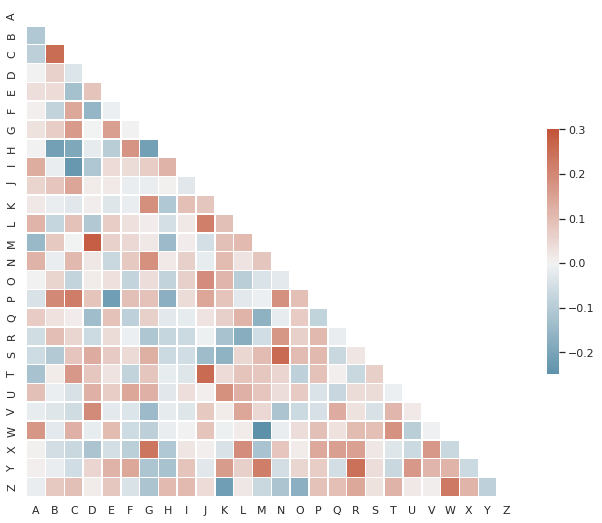

In [59]:
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
